In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar y Preprocesar los Datos

In [46]:
# Cargar el archivo proporcionado
file_path = 'D://Facu/2024/2C/Aprendizaje Automatico/Trabajo final/deteccion_de_estacionalidad_en_crimen/data/external/delitos_correjido.xlsx'
df = pd.read_excel(file_path)

# Renombrar la primera columna para mayor claridad
df.rename(columns={df.columns[0]: 'Tipo de Delito'}, inplace=True)

# Filtrar los nombres actuales de las columnas que contienen datos de meses y años
column_names = df.columns[1:]
mes_anio_columns = []

# Definir los años y meses que vamos a utilizar
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sept', 'oct', 'nov', 'dic']
anios = list(range(2014, 2025))

# Ajustar el proceso de renombrado
anio_index = 0
for i, column in enumerate(column_names):
    if anio_index < len(anios):
        mes = meses[i % len(meses)]
        anio = anios[anio_index]

        mes_anio_columns.append(f"{mes}_{anio}")

        # Incrementar el índice de año cada 12 meses
        if mes == 'dic':
            anio_index += 1
    else:
        break

# Renombrar las columnas de acuerdo con los nuevos nombres generados
df_cleaned = df.copy()
df_cleaned.columns = ['Tipo de Delito'] + mes_anio_columns + list(df.columns[len(mes_anio_columns) + 1:])

# Transformar los datos con 'melt' para obtener un formato largo, incluyendo solo las categorías principales
categorias_principales = ["Contra las Personas", "Otros Delitos Contra las Personas", "Contra la Propiedad"]

data_dict = {}
for categoria in categorias_principales:
    # Seleccionar las filas correspondientes a la categoría principal
    df_categoria = df_cleaned[df_cleaned['Tipo de Delito'] == categoria]
    
    # Transformar los datos para tener una estructura adecuada con 'melt'
    df_melted = df_categoria.melt(id_vars=['Tipo de Delito'], var_name='Mes_Año', value_name='Cantidad')
    
    # Limpiar los datos derretidos: eliminar filas con valores nulos en 'Cantidad'
    df_melted = df_melted.dropna(subset=['Cantidad'])
    
    # Separar la columna 'Mes_Año' en 'Mes' y 'Año'
    df_melted['Año'] = df_melted['Mes_Año'].str.extract(r'(\d{4})$')  # Extraer el año (los últimos 4 caracteres)
    df_melted['Mes'] = df_melted['Mes_Año'].str.extract(r'^(\w+)_')   # Extraer el mes (antes del guion bajo)
    df_melted['Año'] = df_melted['Año'].astype(int)
    
    # Convertir los nombres de los meses a números
    meses_dict = {'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4, 'may': 5, 'jun': 6,
                  'jul': 7, 'ago': 8, 'sept': 9, 'oct': 10, 'nov': 11, 'dic': 12}
    df_melted['Mes'] = df_melted['Mes'].map(meses_dict)
    
    # Guardar los datos en el diccionario
    data_dict[categoria] = df_melted

# Crear un DataFrame consolidado para análisis con las categorías principales
df_analysis = pd.concat(data_dict.values(), ignore_index=True)

# Reorganizar las columnas para mejor comprensión
df_analysis = df_analysis[['Tipo de Delito', 'Año', 'Mes', 'Cantidad']]

# Crear la columna de fecha con un valor predeterminado para el día (1 de cada mes)
df_analysis['Fecha'] = pd.to_datetime(df_analysis.apply(lambda row: f"{int(row['Año'])}-{int(row['Mes']):02d}-01", axis=1), errors='coerce')
df_analysis.dropna(subset=['Fecha'], inplace=True)

# Verificar duplicados y eliminarlos si es necesario
df_analysis.drop_duplicates(subset=['Fecha', 'Tipo de Delito'], keep='first', inplace=True)

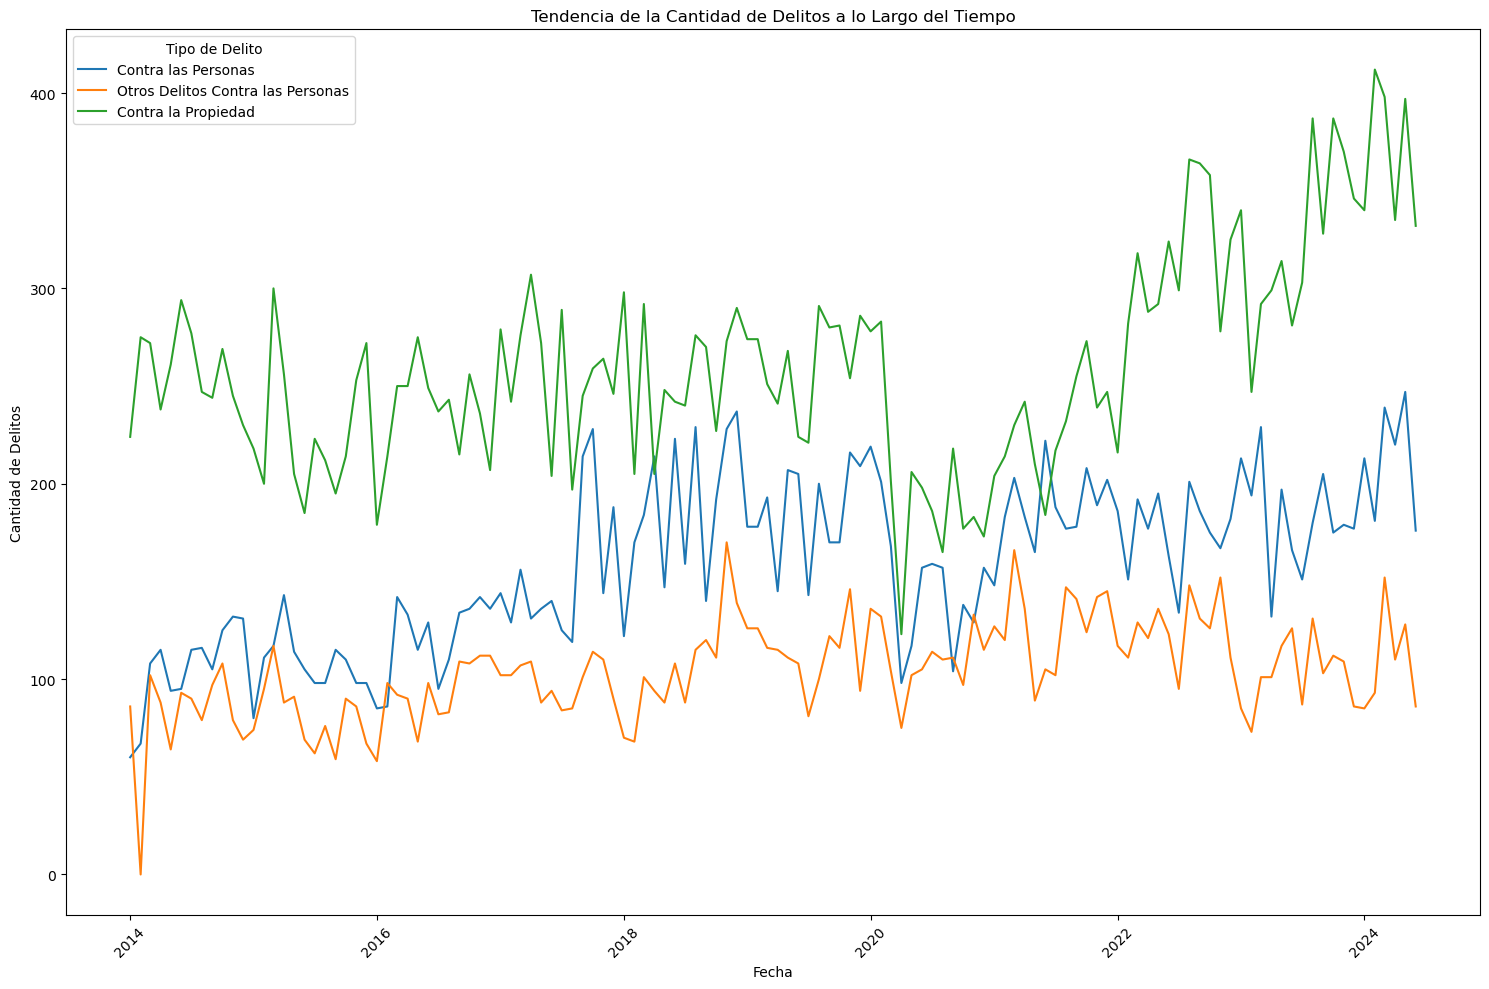

In [48]:
# Gráfico de la tendencia de cada tipo de delito a lo largo del tiempo
plt.figure(figsize=(15, 10))
sns.lineplot(data=df_analysis, x='Fecha', y='Cantidad', hue='Tipo de Delito')
plt.title('Tendencia de la Cantidad de Delitos a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Delitos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

### Preparación de los datos para modelado

In [53]:
# Se utilizará Año, Mes y Tipo de Delito (como variable categórica) para predecir la Cantidad de delitos
df_analysis_model = df_analysis.copy()
df_analysis_model = pd.get_dummies(df_analysis_model, columns=['Tipo de Delito'], drop_first=True)

# Actualizar las variables independientes sin incluir la categoría omitida
X = df_analysis_model[['Mes', 'Tipo de Delito_Contra las Personas', 'Tipo de Delito_Otros Delitos Contra las Personas']]
y = df_analysis_model['Cantidad']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modelos de Aprendizaje Automático

In [56]:
# Modelo 1: Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

In [58]:
# Modelo 2: Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [60]:
# Modelo 3: Support Vector Regressor
model_svr = SVR(kernel='rbf', C=100, gamma=0.1)
model_svr.fit(X_train, y_train)
y_pred_svr = model_svr.predict(X_test)

In [62]:
# Evaluación de los modelos
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Modelo: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R2 Score: {r2:.2f}\n")

In [64]:
# Evaluar los tres modelos
evaluate_model(y_test, y_pred_lr, "Regresión Lineal")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")
evaluate_model(y_test, y_pred_svr, "Support Vector Regressor")

Modelo: Regresión Lineal
Mean Squared Error (MSE): 2150.95
R2 Score: 0.65

Modelo: Random Forest Regressor
Mean Squared Error (MSE): 2297.24
R2 Score: 0.63

Modelo: Support Vector Regressor
Mean Squared Error (MSE): 2585.43
R2 Score: 0.58



### Incorporacion de Año en las variables independientes

In [70]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Reintroducir el Año en las variables independientes
X = df_analysis_model[['Año', 'Mes', 'Tipo de Delito_Contra las Personas', 'Tipo de Delito_Otros Delitos Contra las Personas']]
y = df_analysis_model['Cantidad']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Modelo 1: Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# Modelo 2: Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Modelo 3: Support Vector Regressor
model_svr = SVR(kernel='rbf', C=100, gamma=0.1)
model_svr.fit(X_train, y_train)
y_pred_svr = model_svr.predict(X_test)

In [74]:
# Evaluación de los modelos
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Modelo: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R2 Score: {r2:.2f}\n")
    
# Evaluar los tres modelos
evaluate_model(y_test, y_pred_lr, "Regresión Lineal")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")
evaluate_model(y_test, y_pred_svr, "Support Vector Regressor")


Modelo: Regresión Lineal
Mean Squared Error (MSE): 1495.77
R2 Score: 0.76

Modelo: Random Forest Regressor
Mean Squared Error (MSE): 795.69
R2 Score: 0.87

Modelo: Support Vector Regressor
Mean Squared Error (MSE): 1907.59
R2 Score: 0.69



### Con ajuste de hiperparámetros

In [93]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Reintroducir el Año en las variables independientes
X = df_analysis_model[['Año', 'Mes', 'Tipo de Delito_Contra las Personas', 'Tipo de Delito_Otros Delitos Contra las Personas']]
y = df_analysis_model['Cantidad']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo 1: Regresión Lineal (Ajuste de Hiperparámetros para Ridge Regression)
from sklearn.linear_model import Ridge

param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=3, n_jobs=-1, verbose=2)
grid_ridge.fit(X_train, y_train)

# Modelo 2: Random Forest Regressor con ajuste leve de hiperparámetros
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

# Mejor modelo Random Forest después del ajuste
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Modelo 3: XGBoost Regressor
param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_xgb.fit(X_train, y_train)

# Mejor modelo XGBoost después del ajuste
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluar los tres modelos
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Modelo: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R2 Score: {r2:.2f}\n")

# Evaluar los modelos después del ajuste
evaluate_model(y_test, y_pred_lr, "Regresión Lineal (Ajustado)")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor (Ajustado)")
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor (Ajustado)")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Modelo: Regresión Lineal (Ajustado)
Mean Squared Error (MSE): 1495.77
Mean Absolute Error (MAE): 30.64
R2 Score: 0.76

Modelo: Random Forest Regressor (Ajustado)
Mean Squared Error (MSE): 828.33
Mean Absolute Error (MAE): 22.98
R2 Score: 0.86

Modelo: XGBoost Regressor (Ajustado)
Mean Squared Error (MSE): 814.22
Mean Absolute Error (MAE): 23.42
R2 Score: 0.87



### Conclusiones del Análisis Exploratorio

Los delitos "Contra la Propiedad" presentan picos estacionales, coincidiendo con el verano (meses de diciembre a marzo), lo cual podría deberse a un aumento en la actividad turística y menor supervisión de propiedades.
Los delitos "Contra las Personas" y "Otros Delitos Contra las Personas" también muestran fluctuaciones, aunque menos pronunciadas que los delitos contra la propiedad.

Se desarrollaron tres modelos para predecir la cantidad de delitos a partir de variables temporales(Sin incluir el año):

Modelo: Regresión Lineal
Mean Squared Error (MSE): 2150.95
R2 Score: 0.65

Modelo: Random Forest Regressor
Mean Squared Error (MSE): 2297.24
R2 Score: 0.63

Modelo: Support Vector Regressor
Mean Squared Error (MSE): 2585.43
R2 Score: 0.58

1. Regresión Lineal:
   MSE: 2150.95
   R2 Score: 0.65

2. Random Forest Regressor:
   MSE: 2297.24
   R2 Score: 0.63

3. Support Vector Regressor:
   MSE: 2585.43
   R2 Score: 0.58

Se desarrollaron nuevamente los mismos tres modelos para predecir la cantidad de delitos a partir de variables temporales( inclui el año):   

1. Modelo: Regresión Lineal
Mean Squared Error (MSE): 1495.77
R2 Score: 0.76

2. Modelo: Random Forest Regressor
   Mean Squared Error (MSE): 795.69
   R2 Score: 0.87

3. Modelo: Support Vector Regressor
   Mean Squared Error (MSE): 1907.59
   R2 Score: 0.69

Realizando cambios en los hiperparametros, y cabiando Random Forest Regressor por XGBoost Regressor(ajustado)

1. Modelo: Regresión Lineal (Ajustado)
   Mean Squared Error (MSE): 1495.77
   Mean Absolute Error (MAE): 30.64
   R2 Score: 0.76

2. Modelo: Random Forest Regressor (Ajustado)
   Mean Squared Error (MSE): 828.33
   Mean Absolute Error (MAE): 22.98
   R2 Score: 0.86
   

3. Modelo: XGBoost Regressor (Ajustado)
   Mean Squared Error (MSE): 814.22
   Mean Absolute Error (MAE): 23.42
   R2 Score: 0.87
   
**Interpretación de Resultados y Conclusiones Finales*

Importancia de la Variable "Año":

La inclusión del año como una característica fue un factor crucial en la mejora del rendimiento de todos los modelos. Sin el año, los modelos solo podían capturar la estacionalidad a lo largo de los meses, lo cual no era suficiente para explicar la variabilidad completa en los datos. Con la inclusión del año, se añadieron las tendencias temporales que permitieron a los modelos predecir de manera más precisa.
Mejor Modelo: Random Forest vs. XGBoost:

Tanto el Random Forest Regressor como el XGBoost Regressor mostraron un rendimiento excelente al incluir el año, con R² Scores de 0.86-0.87 y MSEs bajos.
XGBoost mostró el MSE más bajo y un R² Score ligeramente superior, lo cual lo convierte en la mejor opción de los tres modelos para este problema. Random Forest también es una buena alternativa, ya que su rendimiento fue comparable.
Ambos modelos fueron efectivos para capturar patrones complejos y estacionales en la incidencia de delitos.
Rendimiento de la Regresión Lineal:

La Regresión Lineal mostró un rendimiento aceptable al incluir el año, con un R² Score de 0.76, lo cual indica que puede ser una opción viable si se busca un modelo simple y rápido.
Sin embargo, el rendimiento de Ridge Regression no mejoró significativamente con respecto a la Regresión Lineal estándar, lo que sugiere que la regularización no tuvo un impacto importante en este contexto.
Conclusión Sobre la Estacionalidad:

Los modelos confirmaron que los delitos "Contra la Propiedad" presentan picos estacionales claros durante los meses de verano (diciembre a marzo), probablemente debido a un aumento en la actividad turística y menor supervisión de propiedades.
Los delitos "Contra las Personas" y "Otros Delitos Contra las Personas" también presentan fluctuaciones estacionales, aunque menos marcadas.
Mejores Recomendaciones:

XGBoost Regressor o Random Forest Regressor son las opciones preferidas para capturar patrones tanto estacionales como a largo plazo. Ambos modelos son efectivos para manejar la complejidad de los datos de delitos.
Para una implementación simple, la Regresión Lineal sigue siendo una opción razonable, aunque tiene limitaciones en cuanto a la cantidad de variabilidad que puede explicar.
En general, la inclusión del año como variable fue la clave para mejorar la precisión de los modelos y comprender mejor la dinámica temporal de los delitos. Los modelos más complejos, como XGBoost y Random Forest, se destacan por su capacidad de capturar patrones complejos y no lineales, haciendo de ellos la mejor elección para predecir la cantidad de delitos y facilitar una planificación efectiva de recursos de seguridad.

### Preguntas de Investigacion

**¿Existen patrones estacionales claros en la incidencia de ciertos tipos de delitos en la Provincia de Tierra del Fuego?**

Sí, existen patrones estacionales claros. Los delitos "Contra la Propiedad" presentan un incremento significativo durante los meses de verano (diciembre a marzo). Esto coincide con los períodos de mayor actividad turística y podría estar relacionado con una menor supervisión de propiedades. Los delitos "Contra las Personas" y "Otros Delitos Contra las Personas" también muestran fluctuaciones estacionales, aunque de forma menos pronunciada que los delitos contra la propiedad.

**¿Cuáles son los tipos de delitos que muestran una mayor correlación con ciertos meses o estaciones del año?**

Los delitos "Contra la Propiedad" muestran una correlación clara con los meses de verano, lo cual puede deberse a factores como el turismo y el descuido de propiedades. Por otro lado, los delitos "Contra las Personas" y "Otros Delitos Contra las Personas" presentan cierta variación a lo largo del año, pero no se observan picos tan significativos como en los delitos contra la propiedad.

**¿Cómo pueden las tendencias estacionales ayudar a predecir aumentos en la actividad delictiva y apoyar la planificación de recursos policiales?**

Las tendencias estacionales identificadas en el análisis pueden ser útiles para la planificación proactiva de los recursos de seguridad. Utilizando modelos como el Random Forest Regressor, que demostró tener buen desempeño (con un R² Score de 0.87), es posible predecir picos de actividad delictiva durante ciertos períodos del año. Esto permitiría a las autoridades locales asignar recursos de manera más eficiente y aumentar la presencia policial durante los meses de mayor riesgo, como el verano.

**Evaluación de Hipótesis**

**H1: Existe una estacionalidad significativa en la ocurrencia de algunos tipos de delitos, con ciertos picos que se repiten en los mismos meses a lo largo de los años.**

El análisis confirma la existencia de una estacionalidad significativa, especialmente en los delitos contra la propiedad, que presentan picos anuales durante los meses de verano. Esto se observa en los gráficos de tendencia y en las predicciones de los modelos, lo cual respalda esta hipótesis.

**H2: Los delitos contra la propiedad presentan una mayor incidencia durante los meses de verano, cuando hay más actividad turística y menos supervisión de las propiedades.**

Esta hipótesis también se confirma. Los delitos "Contra la Propiedad" muestran un aumento claro en los meses de verano (diciembre a marzo). Esta tendencia es consistente año tras año, lo cual refuerza la idea de que la actividad turística y la menor supervisión de propiedades durante esta época influyen en el incremento de este tipo de delitos.

H3: El análisis de series temporales puede predecir con una exactitud razonable los picos de actividad delictiva, permitiendo una mejor distribución de los recursos de seguridad.

Los modelos desarrollados, particularmente el Random Forest Regressor, muestran un buen rendimiento para predecir la cantidad de delitos, con un R² Score de 0.87 y un MSE de 795.69. Esto indica que el análisis de series temporales permite una predicción razonablemente precisa de los picos de actividad delictiva, lo cual podría ayudar en la distribución proactiva de recursos de seguridad.

Conclusión Final

El análisis realizado muestra que existe una estacionalidad significativa en la ocurrencia de delitos en la Provincia de Tierra del Fuego, particularmente para los delitos contra la propiedad, que aumentan durante los meses de verano. Los modelos de aprendizaje automático, como el Random Forest Regressor, permiten predecir estos picos de actividad con una buena precisión, lo cual puede ser de gran utilidad para la planificación y distribución de los recursos policiales. Esto permitiría a las autoridades locales actuar de forma más proactiva y mitigar los picos estacionales de actividad delictiva.